In [1]:
# DW가 아니라 DM에 적재하는걸 할거다
# sql 서버 연결해서 쓰려면
# apt-get update
# apt-get upgrade
# apt-get install mysql-server -y

# service mysql restart

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# matplotlib 한글 꺠짐 방지
# apt-get update
# apt-get install fonts-nanum* 
# apt-get install fontconfig
# fc-cache -fv  # font 캐시 날리기
# rm -rf /root/.cache/matplotlib/  #matplotliob 폰트 캐시 날리기

# jdbc연동에 필요한 jar파일을 클래스 패스와 jar경로에 추가
# /root/spark/conf/spark-default.conf 파일 수정


In [4]:
# !pip install pymysql

In [5]:
# ## 새로 user 생성 후 접속해야 함
# mysql> create user bigMysql@'%' identified by 'bigMysql1234@';
# mysql> grant all privileges on *.* to bigMysql@'%' with grant option;
# ## DMDB(사용할 database) 생성
# mysql> create database etlmysql_root;

In [6]:
import pymysql

In [7]:
from datetime import date, datetime
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import *
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt #그래프 패키지 모듈 등록
%matplotlib inline 


In [8]:
# import platform

# from matplotlib import font_manager, rc
# plt.rcParams['axes.unicode_minus'] = False

# if platform.system() == 'Darwin':  # 맥OS 
#     rc('font', family='AppleGothic')
# elif platform.system() == 'Windows':  # 윈도우
#     path = "c:/Windows/Fonts/malgun.ttf"
#     font_name = font_manager.FontProperties(fname=path).get_name()
#     rc('font', family=font_name)
# else:
#     rc('font', family='NanumGothic')

## Load - DataMart

## JDBC DICT
- jdbc 연결을 위한 기본 정보 구성
    - dbms url ?한글처리 위한 charset정보&timezone
    - 인증정보 (props) {user:, password:}

In [9]:
JDBC = {
      'url':'jdbc:mysql://localhost:3306/etlMysqlDM?characterEncoding=utf8&serverTimezone=Asia/Seoul'
     ,'props':{
      'user':'bigMysql',
      'password':'bigMysql1234@'   
      }
}


### 1. LOC 테이블 저장
- pipeline 코드
    - 내용 변경이 거의 없는 테이블
    - 자동화대상이 아님(airflow 연결 제외)

In [10]:
# 면적 데이터
area = spark.read.csv("/corona_data/tmp/corona_data/sido_area.csv", encoding="CP949", header = True)
popu = spark.read.csv("/corona_data/tmp/sido_population.csv", encoding="CP949", header = True)

In [11]:
area.show(2)
popu.show(2)

+----+----+-----+
| loc|area|ratio|
+----+----+-----+
|서울|605 |  0.6|
|부산|770 |  0.8|
+----+----+-----+
only showing top 2 rows

+----+---------+---------+---------+
| loc|    total|     male|   female|
+----+---------+---------+---------+
|전국|52739009 |26360035 |26378974 |
|서울| 9736027 | 4721977 | 5014050 |
+----+---------+---------+---------+
only showing top 2 rows



In [12]:
areaPop = area.join(popu, on = "loc") \
              .select(col("loc").alias("LOC"), 
                      col("area").alias("AREA"), 
                      col("total").alias("POPU"))
areaPop.show(1)
type(areaPop)

+----+----+--------+
| LOC|AREA|    POPU|
+----+----+--------+
|서울|605 |9736027 |
+----+----+--------+
only showing top 1 row



pyspark.sql.dataframe.DataFrame

### sql.dataframe.DataFrame 클래스의 write 함수
- 대부분의 data resource로 연결 쓰기 진행 가능
    - dbms, hdfs, 기본 filesystem
- mode() : overwrite (기존 테이블 있으면 새로운 레코드 덮어쓰기, 추가가 아닌 테이블은 놔두고 레코드만 새로 쓰기)
- jdbc(url= , table= , properties="연결 인증 데이터") : dbms에 연결하는 방법을 제시(연결 설정해주는 함수)

In [13]:
areaPop.write.mode("overwrite").jdbc(url=JDBC["url"], table="LOC", properties=JDBC["props"])

# 에러 발생 : jdbc connector가 없어서 발생하는 에러
# Py4JJavaError: An error occurred while calling o84.jdbc.
# : java.sql.SQLException: No suitable driver
# - 약속된 위치에 connector를 저장해둬야함 : 커넥터 jar 파일 다운받아서 저장 

### 2. 테이블 저장
- 하루 한번씩 발표하는 일간 데이터이므로 airflow로 자동화 진행 예정
- 필요한 컬럼 추출한 후에 df에 저장
- 모든일자 json파일 읽어와서 df로 생성후에 필요 컬럼을 선택, df로 다시구성 -> db에 저장
- 매일 새로운 data가 추가되기때문에 기존 table에 append하는 작업이 진행되어야 함 -- append

In [14]:
# 코로나 환자 data hdfs(DM) -> df
# spark.read.json("디렉터리명") : 해당 디렉터리의 json을 모두 읽어 df 로 반환
file_name = "hdfs://localhost:9000/corona_data/patient/"
coToDF = spark.read.json(file_name, encoding = "UTF-8")

In [15]:
# 디렉터리(patient) 내 json파일 1개가 1개의 행(레코드)
coToDF.show()

+-----------------------+---------+------+----------+--------------+----------+
|                  items|numOfRows|pageNo|resultCode|     resultMsg|totalCount|
+-----------------------+---------+------+----------+--------------+----------+
|[{65, 7503, 울산, 蔚...|      500|     1|        00|NORMAL SERVICE|        19|
| [{348, 28711, 부산,...|      500|     1|        00|NORMAL SERVICE|        19|
| [{327, 41467, 인천,...|      500|     1|        00|NORMAL SERVICE|        19|
| [{326, 40625, 인천,...|      500|     1|        00|NORMAL SERVICE|        19|
|[{45, 7630, 전남, 全...|      500|     1|        00|NORMAL SERVICE|        19|
|[{13, 4897, 제주, 济...|      500|     1|        00|NORMAL SERVICE|        19|
+-----------------------+---------+------+----------+--------------+----------+



In [16]:
# items 컬럼을 활용해서 df 다시 생성 - 컬럼의 data가 6행(레코드)
# 반환 후 action 모듈 : first(), collect()
type(coToDF.select(coToDF.items))
print(len(coToDF.select(coToDF.items).collect()))
coToDF.select(coToDF.items).collect()[0]

pyspark.sql.dataframe.DataFrame

6


Row(items=[Row(deathCnt='65', defCnt='7503', gubun='울산', gubunCn='蔚山', gubunEn='Ulsan', incDec='44', isolClearCnt='7137', isolIngCnt='0', localOccCnt='44', overFlowCnt='0', qurRate='669', stdDay='2022-01-19'), Row(deathCnt='62', defCnt='10701', gubun='광주', gubunCn='光州', gubunEn='Gwangju', incDec='226', isolClearCnt='8523', isolIngCnt='0', localOccCnt='218', overFlowCnt='8', qurRate='742', stdDay='2022-01-19'), Row(deathCnt='190', defCnt='17132', gubun='경북', gubunCn='庆北', gubunEn='Gyeongsangbuk-do', incDec='170', isolClearCnt='15280', isolIngCnt='0', localOccCnt='151', overFlowCnt='19', qurRate='652', stdDay='2022-01-19'), Row(deathCnt='386', defCnt='25368', gubun='대구', gubunCn='大邱', gubunEn='Daegu', incDec='213', isolClearCnt='23498', isolIngCnt='0', localOccCnt='197', overFlowCnt='16', qurRate='1063', stdDay='2022-01-19'), Row(deathCnt='123', defCnt='12636', gubun='충북', gubunCn='忠北', gubunEn='Chungcheongbuk-do', incDec='81', isolClearCnt='11803', isolIngCnt='0', localOccCnt='79', over

In [17]:
# 각 날짜에 대한 지역별 레코드를 구성하기 위한 작업
# 리스트에 레코드를 저장하고 df로 구성 : 구조 Rows[Rows[]]의 형태인거임
# collect()로 반환 받은 후에 진행할수도 있고
# spark.sql.df.toLocalIterator() : df에서 각 레코드를 반환해주는 역할을 하는 함수, df에 적용되면 row객체를 반환
data = []
for rdd1 in coToDF.select(coToDF.items).toLocalIterator():
    for item in rdd1.items :
        data.append(item)
len(data) 

[Stage 13:>                                                         (0 + 1) / 1]

114

In [18]:
tmpDF = spark.createDataFrame(data)
tmpDF.show(tmpDF.count())

+--------+------+-----+-------+-----------------+------+------------+----------+-----------+-----------+-------+----------+
|deathCnt|defCnt|gubun|gubunCn|          gubunEn|incDec|isolClearCnt|isolIngCnt|localOccCnt|overFlowCnt|qurRate|    stdDay|
+--------+------+-----+-------+-----------------+------+------------+----------+-----------+-----------+-------+----------+
|      65|  7503| 울산|   蔚山|            Ulsan|    44|        7137|         0|         44|          0|    669|2022-01-19|
|      62| 10701| 광주|   光州|          Gwangju|   226|        8523|         0|        218|          8|    742|2022-01-19|
|     190| 17132| 경북|   庆北| Gyeongsangbuk-do|   170|       15280|         0|        151|         19|    652|2022-01-19|
|     386| 25368| 대구|   大邱|            Daegu|   213|       23498|         0|        197|         16|   1063|2022-01-19|
|     123| 12636| 충북|   忠北|Chungcheongbuk-do|    81|       11803|         0|         79|          2|    791|2022-01-19|
|       4|  2414| 세종|   世宗| 

In [19]:
# 필요컬럼 추출 --> 불필요한 행 제거 --> 동일 날짜 동일 데이터가 2개 이상 있으면 1개만 남기고 제거(distinct)
coPDF = tmpDF.select(
    tmpDF.gubun.alias("LOC"),
    tmpDF.deathCnt.alias("DEATH_CNT"),
    tmpDF.defCnt.alias("DEF_CNT"), 
    tmpDF.localOccCnt.alias("LOC_OCC_CNT"),
    tmpDF.qurRate.alias("QUR_RATE"),
    tmpDF.stdDay.alias("STD_DAY")
    ) \
    .where(~(col("LOC").isin(["합계", "검역"]))).distinct()
coPDF.show()

+----+---------+-------+-----------+--------+----------+
| LOC|DEATH_CNT|DEF_CNT|LOC_OCC_CNT|QUR_RATE|   STD_DAY|
+----+---------+-------+-----------+--------+----------+
|강원|      110|  13838|         94|     899|2022-01-18|
|서울|     2063| 243337|        684|    2559|2022-01-18|
|대전|      187|  13262|        101|     913|2022-01-18|
|전북|      121|  11094|        114|     621|2022-01-17|
|광주|       55|  10049|        173|     697|2022-01-16|
|세종|        4|   2359|         20|     634|2022-01-16|
|전북|      121|  11245|        147|     629|2022-01-18|
|전남|       45|   7630|        160|     416|2022-01-16|
|충북|      121|  12455|         37|     780|2022-01-16|
|경기|     2036| 210984|       1470|    1555|2022-01-18|
|경기|     2014| 208027|       1511|    1534|2022-01-16|
|경남|      114|  22778|        134|     687|2022-01-18|
|서울|     2051| 242574|        711|    2551|2022-01-17|
|경북|      188|  16824|         87|     641|2022-01-17|
|충북|      121|  12497|         38|     782|2022-01-17|
|대전|

In [20]:
coPDF.where(col("STD_DAY") == "2022-01-18").show()

+----+---------+-------+-----------+--------+----------+
| LOC|DEATH_CNT|DEF_CNT|LOC_OCC_CNT|QUR_RATE|   STD_DAY|
+----+---------+-------+-----------+--------+----------+
|강원|      110|  13838|         94|     899|2022-01-18|
|서울|     2063| 243337|        684|    2559|2022-01-18|
|대전|      187|  13262|        101|     913|2022-01-18|
|전북|      121|  11245|        147|     629|2022-01-18|
|경기|     2036| 210984|       1470|    1555|2022-01-18|
|경남|      114|  22778|        134|     687|2022-01-18|
|광주|       60|  10475|        174|     727|2022-01-18|
|전남|       45|   7935|        138|     433|2022-01-18|
|세종|        4|   2388|         21|     642|2022-01-18|
|충남|      177|  20142|        140|     950|2022-01-18|
|경북|      189|  16962|        129|     646|2022-01-18|
|울산|       65|   7459|         33|     665|2022-01-18|
|대구|      385|  25155|        162|    1055|2022-01-18|
|부산|      344|  28102|        102|     839|2022-01-18|
|인천|      326|  40625|        177|    1378|2022-01-18|
|제주|

- mode : append (기존 테이블 있으면 테이블에 레코드 추가)

In [21]:
coPDF.write.jdbc(url=JDBC["url"], table="CORONA_PATIENTS", mode="append", properties=JDBC["props"])

### 3. CORONA_VACCINE 테이블 저장

In [22]:
# vaccine 폴더 내에 있는 json 파일 모두 읽어오기
file_name = "/corona_data/vaccine/"
vaccine = spark.read.json(file_name, encoding="UTF-8")

In [23]:
vaccine.show()

+----------------------+---------------------------+
|                  data|                       meta|
+----------------------+---------------------------+
|[{광주, 1247764, 12...|{{지역, 1차 접종 누적, 2...|
|[{세종, 290049, 281...|{{지역, 1차 접종 누적, 2...|
|[{세종, 289482, 278...|{{지역, 1차 접종 누적, 2...|
|[{울산, 955638, 927...|{{지역, 1차 접종 누적, 2...|
|[{울산, 955163, 925...|{{지역, 1차 접종 누적, 2...|
|[{울산, 956453, 930...|{{지역, 1차 접종 누적, 2...|
|[{대전, 1230930, 12...|{{지역, 1차 접종 누적, 2...|
+----------------------+---------------------------+



In [24]:
vaccine.select(vaccine.data.loc.alias("LOC"), vaccine.meta.stdDay).show()

+----------------------------+-----------+
|                         LOC|meta.stdDay|
+----------------------------+-----------+
|[광주, 울산, 인천, 대전, ...| 2022-01-21|
|[세종, 광주, 인천, 대전, ...| 2022-01-15|
|[세종, 대전, 인천, 광주, ...| 2022-01-12|
|[울산, 대전, 광주, 인천, ...| 2022-01-14|
|[울산, 대전, 광주, 인천, ...| 2022-01-13|
|[울산, 대전, 인천, 광주, ...| 2022-01-16|
|[대전, 울산, 광주, 인천, ...| 2022-01-17|
+----------------------------+-----------+



In [25]:
# vaccine data는 기준일 stdDay가 meta컬럼에 있음
tmpData = []
for rdd1 in vaccine.select(vaccine.data, vaccine.meta.stdDay).toLocalIterator():
    for data in rdd1.data :
        temp=data.asDict() # 특정일의 한 지역 데이터
        temp["std_day"] = rdd1["meta.stdDay"] # 데이터 수집 기준일을 지역 data에 포함
        tmpData.append(Row(**temp)) # dict를 row로 변환해줘야 spark.df 객체로 가능하다

In [26]:
vacTmp = spark.createDataFrame(tmpData)

In [27]:
vacTmp.show()

+----+--------+----------+----------+----------+
| loc|      v1|        v2|        v3|   std_day|
+----+--------+----------+----------+----------+
|광주| 1247764| 1220758.0|  682394.0|2022-01-21|
|울산|  956895|  933311.0|  476692.0|2022-01-21|
|인천| 2532911| 2484196.0| 1330273.0|2022-01-21|
|대전| 1231435| 1203724.0|  628469.0|2022-01-21|
|대구| 1997407| 1945813.0|  978794.0|2022-01-21|
|부산| 2849093| 2788089.0| 1554554.0|2022-01-21|
|서울| 8239400| 8090244.0| 4304485.0|2022-01-21|
|전국|44505276|43582128.0|23741205.0|2022-01-21|
|세종|  290455|  282507.0|  138100.0|2022-01-21|
|경기|11652853|11414202.0| 5970505.0|2022-01-21|
|제주|  580579|  566811.0|  295807.0|2022-01-21|
|경남| 2848083| 2783896.0| 1517240.0|2022-01-21|
|경북| 2260963| 2202814.0| 1247047.0|2022-01-21|
|전남| 1632045| 1602479.0| 1031459.0|2022-01-21|
|전북| 1574779| 1547262.0|  958100.0|2022-01-21|
|충남| 1870124| 1830143.0| 1048429.0|2022-01-21|
|충북| 1408620| 1379378.0|  783588.0|2022-01-21|
|강원| 1331870| 1306501.0|  795269.0|2022-01-21|
|세종|  2

In [28]:
coVacDF = vacTmp.where(~(col("LOC").isin(["전국", "기타"]))).distinct()
coVacDF.show()

+----+--------+----------+-------+----------+
| loc|      v1|        v2|     v3|   std_day|
+----+--------+----------+-------+----------+
|대전| 1230936| 1201356.0| 8242.0|2022-01-16|
|울산|  956456|  930969.0|  240.0|2022-01-17|
|서울| 8235942| 8078465.0|53011.0|2022-01-16|
|전남| 1629691| 1593531.0|11070.0|2022-01-13|
|부산| 2847993| 2783249.0|19131.0|2022-01-16|
|인천| 2531621| 2480078.0|21679.0|2022-01-16|
|제주|  580252|  565511.0| 2907.0|2022-01-16|
|제주|  580267|  565580.0|  221.0|2022-01-17|
|강원| 1329749| 1298927.0| 9489.0|2022-01-13|
|인천| 2531729| 2480340.0| 1396.0|2022-01-17|
|경남| 2846948| 2778447.0|18787.0|2022-01-16|
|경기|11635521|11361626.0|86734.0|2022-01-14|
|충북| 1407989| 1376714.0| 9444.0|2022-01-16|
|경기|11646846|11394192.0|93399.0|2022-01-16|
|전북| 1574264| 1544854.0|10070.0|2022-01-16|
|전북| 1572742| 1537974.0| 9890.0|2022-01-13|
|전남| 1631390| 1600290.0|  261.0|2022-01-17|
|대전| 1230930| 1201442.0|  315.0|2022-01-17|
|서울| 8227788| 8049504.0|46088.0|2022-01-13|
|전북| 1573274| 1540820.0|11

In [48]:
# 백신 접종이 4차 접종으로 확장된다면?? 위 df를 table로 구성했을 때, v4컬럼을 추가해야함
# 컬럼 추가는 테이블 구조를 변경하게 되는 것 --> 접종차수를 컬럼으로 만들기 보다는 value로 구성하는게 더 효율적
# pandas.df로 변경 후 df 구성 변경
pdcoVac = coVacDF.pandas_api() # 스파크 판다스를 이용하겠다
pdcoVac.head()
type(pdcoVac)

,loc,v1,v2,v3,std_day
0,대전,1230936,1201356.0,8242.0,2022-01-16
1,울산,956456,930969.0,240.0,2022-01-17
2,서울,8235942,8078465.0,53011.0,2022-01-16
3,전남,1629691,1593531.0,11070.0,2022-01-13
4,부산,2847993,2783249.0,19131.0,2022-01-16


pyspark.pandas.frame.DataFrame

In [49]:
# 행 idx는 dbms 테이블의 기본키와 같은 역할
pdCoVac = pdcoVac.set_index(["loc", "std_day"])
pdCoVac.head()

,,v1,v2,v3
loc,std_day,,,
대전,2022-01-16,1230936,1201356.0,8242.0
울산,2022-01-17,956456,930969.0,240.0
서울,2022-01-16,8235942,8078465.0,53011.0
전남,2022-01-13,1629691,1593531.0,11070.0
부산,2022-01-16,2847993,2783249.0,19131.0


In [50]:
pdCoVacV1 = pdCoVac.stack() # 이렇게 나온 데이터를 long형이라고 부르는듯
pdCoVacV1

loc  std_day       
대전   2022-01-15  v2     1200346.0
                 v1       1230543
                 v3       16060.0
충남   2022-01-12  v2     1813903.0
                 v1       1865661
                 v3       14912.0
광주   2022-01-21  v2     1220758.0
                 v1       1247764
                 v3      682394.0
서울   2022-01-21  v2     8090244.0
                 v1       8239400
                 v3     4304485.0
경기   2022-01-21  v2    11414202.0
                 v1      11652853
                 v3     5970505.0
부산   2022-01-12  v2     2764441.0
                 v1       2843856
                 v3       21336.0
전북   2022-01-15  v2     1543969.0
                 v1       1573966
                 v3       18794.0
충북   2022-01-15  v2     1375764.0
                 v1       1407536
                 v3       18589.0
대구   2022-01-15  v2     1939414.0
                 v1       1995815
                 v3       23183.0
강원   2022-01-12  v2     1296280.0
                 v1       13

In [51]:
pdCoVac = pdCoVacV1.to_dataframe("V_CNT")
pdCoVac.index

MultiIndex([('대전', '2022-01-16', 'v2'),
            ('대전', '2022-01-16', 'v1'),
            ('대전', '2022-01-16', 'v3'),
            ('울산', '2022-01-17', 'v2'),
            ('울산', '2022-01-17', 'v1'),
            ('울산', '2022-01-17', 'v3'),
            ('서울', '2022-01-16', 'v2'),
            ('서울', '2022-01-16', 'v1'),
            ('서울', '2022-01-16', 'v3'),
            ('전남', '2022-01-13', 'v2'),
            ...
            ('대구', '2022-01-14', 'v3'),
            ('충남', '2022-01-15', 'v2'),
            ('충남', '2022-01-15', 'v1'),
            ('충남', '2022-01-15', 'v3'),
            ('충북', '2022-01-21', 'v2'),
            ('충북', '2022-01-21', 'v1'),
            ('충북', '2022-01-21', 'v3'),
            ('세종', '2022-01-15', 'v2'),
            ('세종', '2022-01-15', 'v1'),
            ('세종', '2022-01-15', 'v3')],
           names=['loc', 'std_day', None], length=357)

In [53]:
pdCoVac.reset_index(inplace= True)
pdCoVac.head() # 이런 데이터 형태로 하면 나중에 v4 v5 이렇게 시간의 흐름에 따른 변화에 좋음

,loc,std_day,level_2,V_CNT
0,대전,2022-01-15,v2,1200346.0
1,대전,2022-01-15,v1,1230543
2,대전,2022-01-15,v3,16060.0
3,충남,2022-01-12,v2,1813903.0
4,충남,2022-01-12,v1,1865661


In [54]:
pdCoVac.rename(columns={"level_2":"V_TH", "loc":"LOC", "std_day":"STD_DAY"})
pdCoVac.head()

,LOC,STD_DAY,V_TH,V_CNT
0,대전,2022-01-16,v2,1201356.0
1,대전,2022-01-16,v1,1230936
2,대전,2022-01-16,v3,8242.0
3,울산,2022-01-17,v2,930969.0
4,울산,2022-01-17,v1,956456
5,울산,2022-01-17,v3,240.0
6,서울,2022-01-16,v2,8078465.0
7,서울,2022-01-16,v1,8235942
8,서울,2022-01-16,v3,53011.0
9,전남,2022-01-13,v2,1593531.0


,loc,std_day,level_2,V_CNT
0,대전,2022-01-15,v2,1200346.0
1,대전,2022-01-15,v1,1230543
2,대전,2022-01-15,v3,16060.0
3,충남,2022-01-12,v2,1813903.0
4,충남,2022-01-12,v1,1865661


In [58]:
coVacDFv1 = pdCoVac.to_spark()
coVacDFv1.show()

+----+----------+-------+---------+
| loc|   std_day|level_2|    V_CNT|
+----+----------+-------+---------+
|대전|2022-01-16|     v2|1201356.0|
|대전|2022-01-16|     v1|  1230936|
|대전|2022-01-16|     v3|   8242.0|
|울산|2022-01-17|     v2| 930969.0|
|울산|2022-01-17|     v1|   956456|
|울산|2022-01-17|     v3|    240.0|
|서울|2022-01-16|     v2|8078465.0|
|서울|2022-01-16|     v1|  8235942|
|서울|2022-01-16|     v3|  53011.0|
|전남|2022-01-13|     v2|1593531.0|
|전남|2022-01-13|     v1|  1629691|
|전남|2022-01-13|     v3|  11070.0|
|부산|2022-01-16|     v2|2783249.0|
|부산|2022-01-16|     v1|  2847993|
|부산|2022-01-16|     v3|  19131.0|
|인천|2022-01-16|     v2|2480078.0|
|인천|2022-01-16|     v1|  2531621|
|인천|2022-01-16|     v3|  21679.0|
|제주|2022-01-16|     v2| 565511.0|
|제주|2022-01-16|     v1|   580252|
+----+----------+-------+---------+
only showing top 20 rows



In [59]:
coVacDFv1.write.jdbc(url=JDBC["url"], table="CORONA_VACCINE", mode ="append", properties=JDBC["props"])

### 4. LOC_FACILITY_CNT	테이블 저장
- 주기적 수집데이터는 아님
    - airflow 자동화 대상 아님
- 파일 자료가 다중이용시설 상호별로 되어있음
- 광역시도별 개수세어서 저장

In [61]:
# https://www.data.go.kr/data/15093402/fileData.do#tab-layer-file
facil = spark.read.csv("/corona_data/tmp/전국다중이용시설.csv", encoding="CP949", header=True)
facil.show()

+----+----+------+---------------------+--------------+----------------+
|연도|광역|시군구|               시설명|사업자등록번호|          시설군|
+----+----+------+---------------------+--------------+----------------+
|2020|강원|강릉시|     (주)경포솔향온천|  127-86-57613|          목욕장|
|2020|강원|강릉시|       24시황실사우나|  226-33-03247|          목욕장|
|2020|강원|강릉시|         강릉고려병원|  226-82-03662|        의료기관|
|2020|강원|강릉시|   강릉고속버스터미널|  219-81-01636|여객자동차터미널|
|2020|강원|강릉시|       강릉교육문화관|  226-83-03107|          도서관|
|2020|강원|강릉시|         강릉동인병원|  226-82-01835|        의료기관|
|2020|강원|강릉시|         강릉동인병원|  226-82-01835|        장례식장|
|2020|강원|강릉시|강릉동인병원 장례식장|  226-90-93776|        장례식장|
|2020|강원|강릉시|   강릉빛나라어린이집|  226-82-12841|        어린이집|
|2020|강원|강릉시|     강릉삼성어린이집|  226-80-04288|        어린이집|
|2020|강원|강릉시|          강릉시 기관|  226-83-00245|          도서관|
|2020|강원|강릉시|          강릉시 기관|  226-83-00245|        어린이집|
|2020|강원|강릉시|          강릉시 기관|  226-83-00245|          박물관|
|2020|강원|강릉시|         강릉시보건소|  226-83-00264|        의료기관|

In [62]:
facCnt = facil.groupby(col("광역").alias("LOC"))\
              .agg(count("*").alias("FAC_CNT"))
facCnt.printSchema()
facCnt.show(5)

root
 |-- LOC: string (nullable = true)
 |-- FAC_CNT: long (nullable = false)

+----+-------+
| LOC|FAC_CNT|
+----+-------+
|경북|    944|
|대전|    767|
|전북|    759|
|충북|    617|
|울산|    431|
+----+-------+
only showing top 5 rows



In [63]:
facCnt.write.jdbc(url=JDBC["url"], table="LOC_FACILITY_CNT", mode="overwrite",  properties=JDBC["props"])

### 지속적으로 자동화해서 데이터 입력할거는 mode 를 append로 
### 가끔 갱신해야하는 경우 mode를 overwrite로 

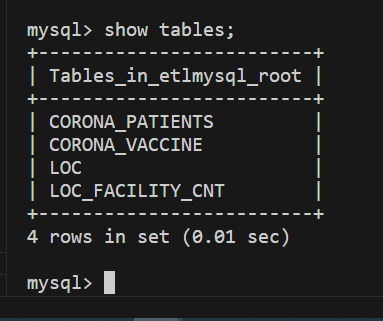